# Load

## Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import ListedColormap

import geopandas as gpd
import shapely

## Data

### Provincias

In [3]:
with open('Provincias.txt') as fh:
    filecont=fh.readlines()

In [4]:
provincia=[]
for line in filecont:
    current=line[:-1]
    provincia.append(current)

### Resultados

In [5]:
Resultado={}
for prov in provincia:
    Resultado[prov]=pd.read_csv('Resultados/'+prov+'.csv',index_col=[0])

### Escaños

In [6]:
with open('Diputados.txt') as fh:
    filecont=fh.readlines()

In [7]:
Diputados={}
for line in filecont:
    key,val=line.split(sep=': ')
    Diputados[key]=pd.to_numeric(val[:-1])

# Calculador de Escaños

In [8]:
def CalcularDiputados(Res,Dips):
    div=np.array([1/i for i in range(1,Dips+1)])
    df=Res['Votos'].apply(lambda x: x*div).apply(pd.Series).unstack().sort_values(ascending=False)[:Dips]
    x=df.index.get_level_values(1).value_counts()
    return x

In [9]:
ResDip={}
for prov in provincia:
    ResDip[prov]=CalcularDiputados(Resultado[prov],Diputados[prov])

# Calcular Parlamento

In [10]:
def Partidos(Res):
    ind=pd.Index(['PP'])
    for prov in Res:
        ind=ind.union(Res[prov].index)
    return ind

In [11]:
def Parlamento(Res):
    Part=Partidos(Res)
    df=pd.DataFrame(data=Res,index=Part,dtype=int).replace(np.nan,0)
    return df.assign(Total=df.sum(axis=1))

In [12]:
Parl=Parlamento(ResDip)

# Partido Mas Votado

In [13]:
def MasVotado(Res):
    df=pd.DataFrame(data=provincia,index=provincia)
    for prov in Res:
        df.loc[prov]=Res[prov].sort_values(by='Votos',ascending=False).index[0]
    return df

In [14]:
MV=MasVotado(Resultado)

# Mapa

In [15]:
map_df=gpd.read_file('Map/ne_10m_admin_1_states_provinces.shp')

In [16]:
esp=map_df.loc[map_df['iso_a2']=='ES']

In [17]:
mapdict={
    'CÃ¡ceres': 'Caceres',
    'LÃ©rida': 'Lleida',
    'Gerona': 'Girona',
    'Orense': 'Oursense',
    'CÃ¡diz': 'Cadiz',
    'CastellÃ³n': 'Castellon',
    'AlmerÃ­a': 'Almeria',
    'MÃ¡laga': 'Malaga',
    'La CoruÃ±a': 'A Coruna',
    'Santa Cruz de Tenerife': 'Tenerife',
    'Baleares': 'Illes Balears',
    'Ãlava': 'Alava',
    'LeÃ³n': 'Leon',
    'Ãvila': 'Avila',
    'CÃ³rdoba': 'Cordoba',
    'JaÃ©n': 'Jaen'
}

In [18]:
esp['geometry'].loc[2825]=shapely.affinity.translate(esp['geometry'].loc[2825], xoff=4, yoff=8)
esp['geometry'].loc[2826]=shapely.affinity.translate(esp['geometry'].loc[2826], xoff=4, yoff=8)

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
esp['prov']=esp['name'].replace(mapdict)

C:\ProgramData\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
merge=esp.set_index('prov').join(MV)

In [21]:
colormap=cm.get_cmap('Blues',5)(np.linspace(0,1,5))

In [22]:
colormap[0]=[243/256,178/256,23/256,1]
colormap[1]=[201/256,28/256,41/256,1]
colormap[2]=[0/256,149/256,38/256,1]
colormap[3]=[0/256,85/256,167/256,1]
colormap[4]=[237/256,28/256,36/256,1]

In [23]:
mycm=ListedColormap(colormap)

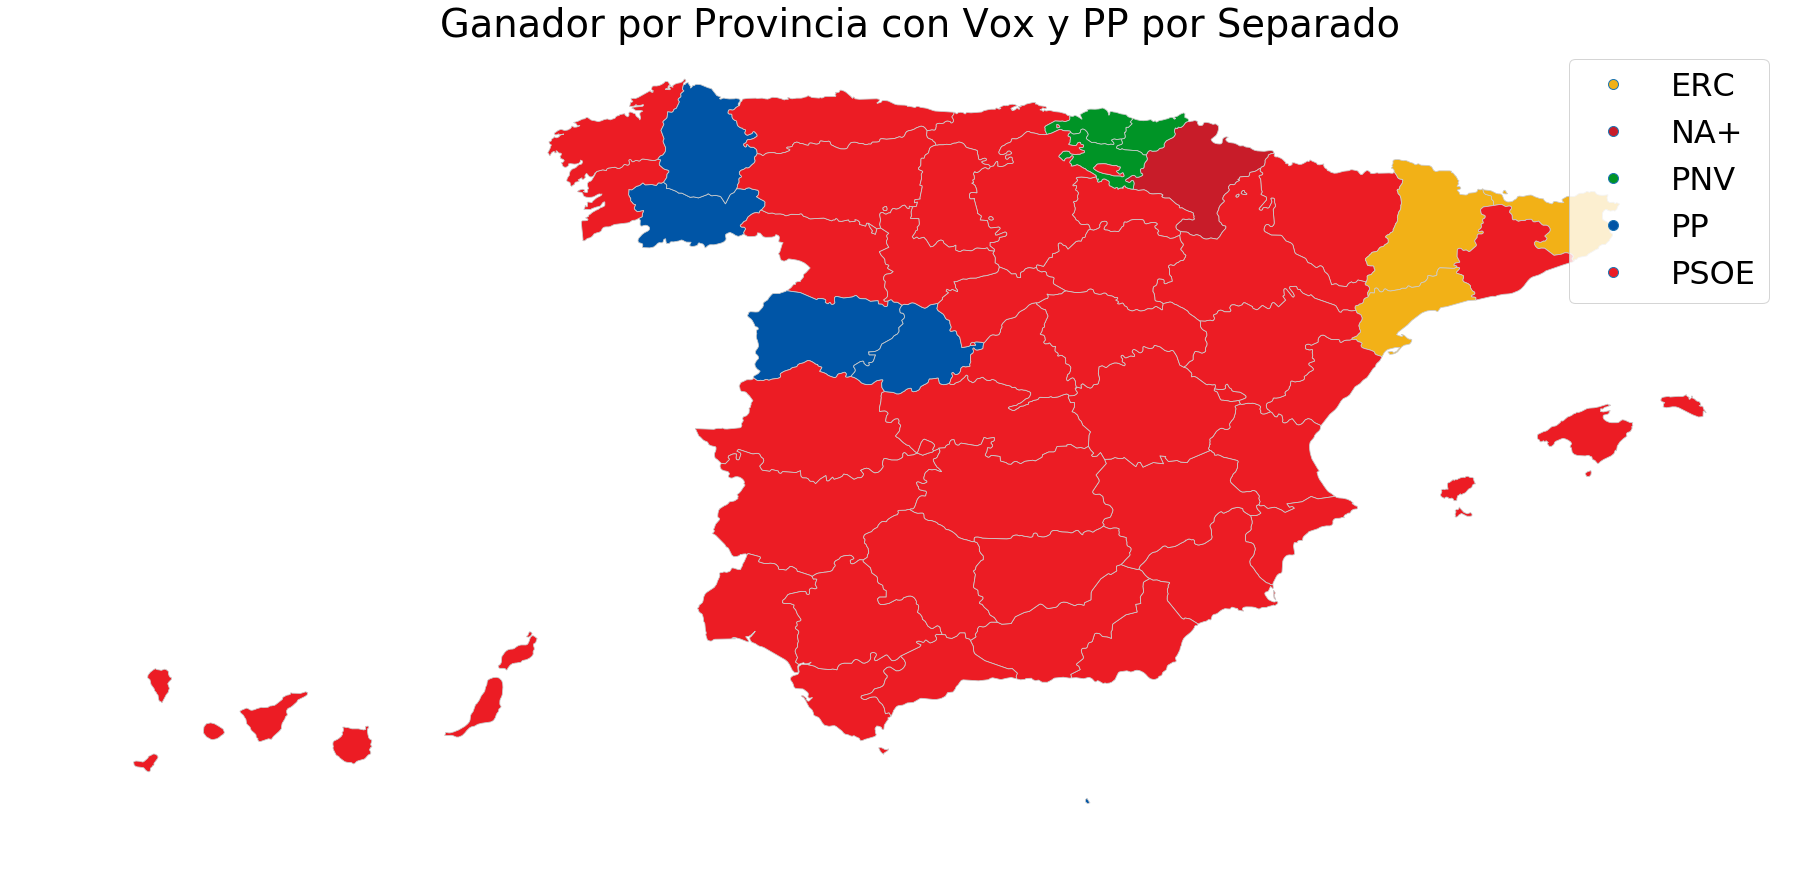

In [24]:
plt.rcParams.update({'font.size':32})

ax=merge.plot(column=0,cmap=mycm,figsize=(31,19),linewidth=0.8,edgecolor='0.8',legend=True,categorical=True)
ax.set_axis_off()
ax.set_title('Ganador por Provincia con Vox y PP por Separado')
plt.show()

# Parlamento

In [25]:
sortedparl=Parl[['Total']].sort_values(by='Total',ascending=False)

In [26]:
lab=list(sortedparl.index)
for l in range(8,len(lab)):
    lab[l]=''

In [27]:
def disp(pct):
    if pct>1.5:
        return '{:.0f}'.format(pct*3.5)

In [28]:
partcol=['#ED1C24','#0055A7','#FA5000','#6A2E68','#5AC035','#F3B217','#C40048','#009526','#A3C940','#FFDA1A','#E51C13','#DB6426','#BECD48']

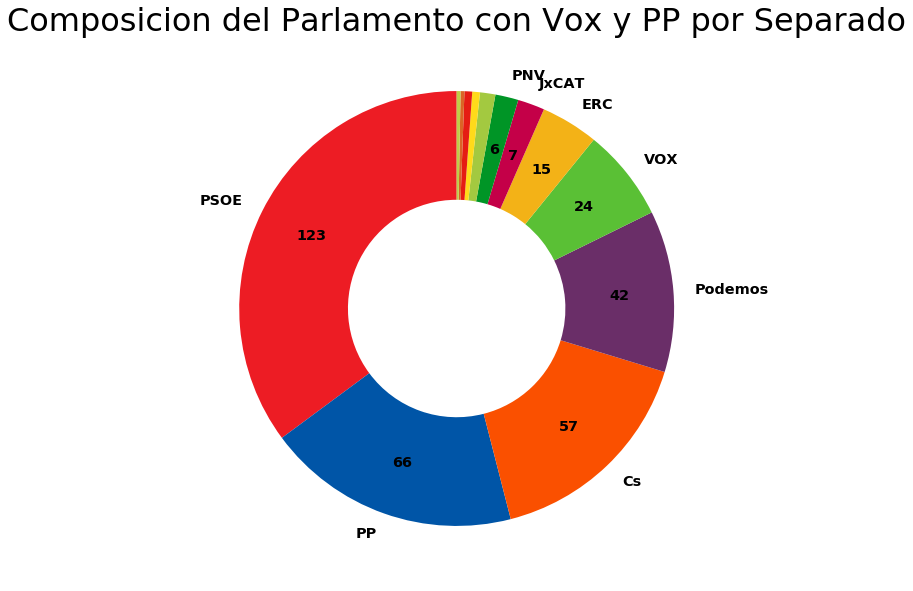

In [29]:
plt.rcParams.update({'font.size':12})

plt.figure(figsize=(10,10))
plt.pie(sortedparl,colors=partcol,wedgeprops=dict(width=0.5),startangle=90,labels=lab,autopct=lambda x: disp(x[0]),pctdistance=0.75,textprops={'fontsize':'large','weight':'bold'})
plt.title('Composicion del Parlamento con Vox y PP por Separado',fontdict={'fontsize':32})
plt.show()

# Cambio Electoral

In [46]:
def NuevoResultado(Res,Part1,Part2,Peso):
    NRes=Res.copy()
    if np.isin('NA+',NRes.index) & ((Part1=='PP') | (Part1=='Cs')):
        Part1='NA+'
    if np.isin(Part1,NRes.index) & np.isin(Part2,NRes.index):
        NRes.loc[Part1]=NRes.loc[Part1]+(NRes.loc[Part2]*Peso)
        NRes.loc[Part2]=NRes.loc[Part2]*(1-Peso)
    return NRes

In [47]:
ResultadoPPVOX={}
for prov in provincia:
    ResultadoPPVOX[prov]=NuevoResultado(Resultado[prov],'PP','VOX',1)

# Calculador de Escaños

In [50]:
ResDipPPVOX={}
for prov in provincia:
    ResDipPPVOX[prov]=CalcularDiputados(ResultadoPPVOX[prov],Diputados[prov])

# Calcular Parlamento

In [51]:
ParlPPVOX=Parlamento(ResDipPPVOX)

# Partido Mas Votado

In [52]:
MVPPVOX=MasVotado(ResultadoPPVOX)

# Mapa

In [53]:
mergePPVOX=esp.set_index('prov').join(MVPPVOX)

In [54]:
colormap=cm.get_cmap('Blues',5)(np.linspace(0,1,5))

In [55]:
colormap[0]=[243/256,178/256,23/256,1]
colormap[1]=[201/256,28/256,41/256,1]
colormap[2]=[0/256,149/256,38/256,1]
colormap[3]=[0/256,85/256,167/256,1]
colormap[4]=[237/256,28/256,36/256,1]

In [56]:
mycm=ListedColormap(colormap)

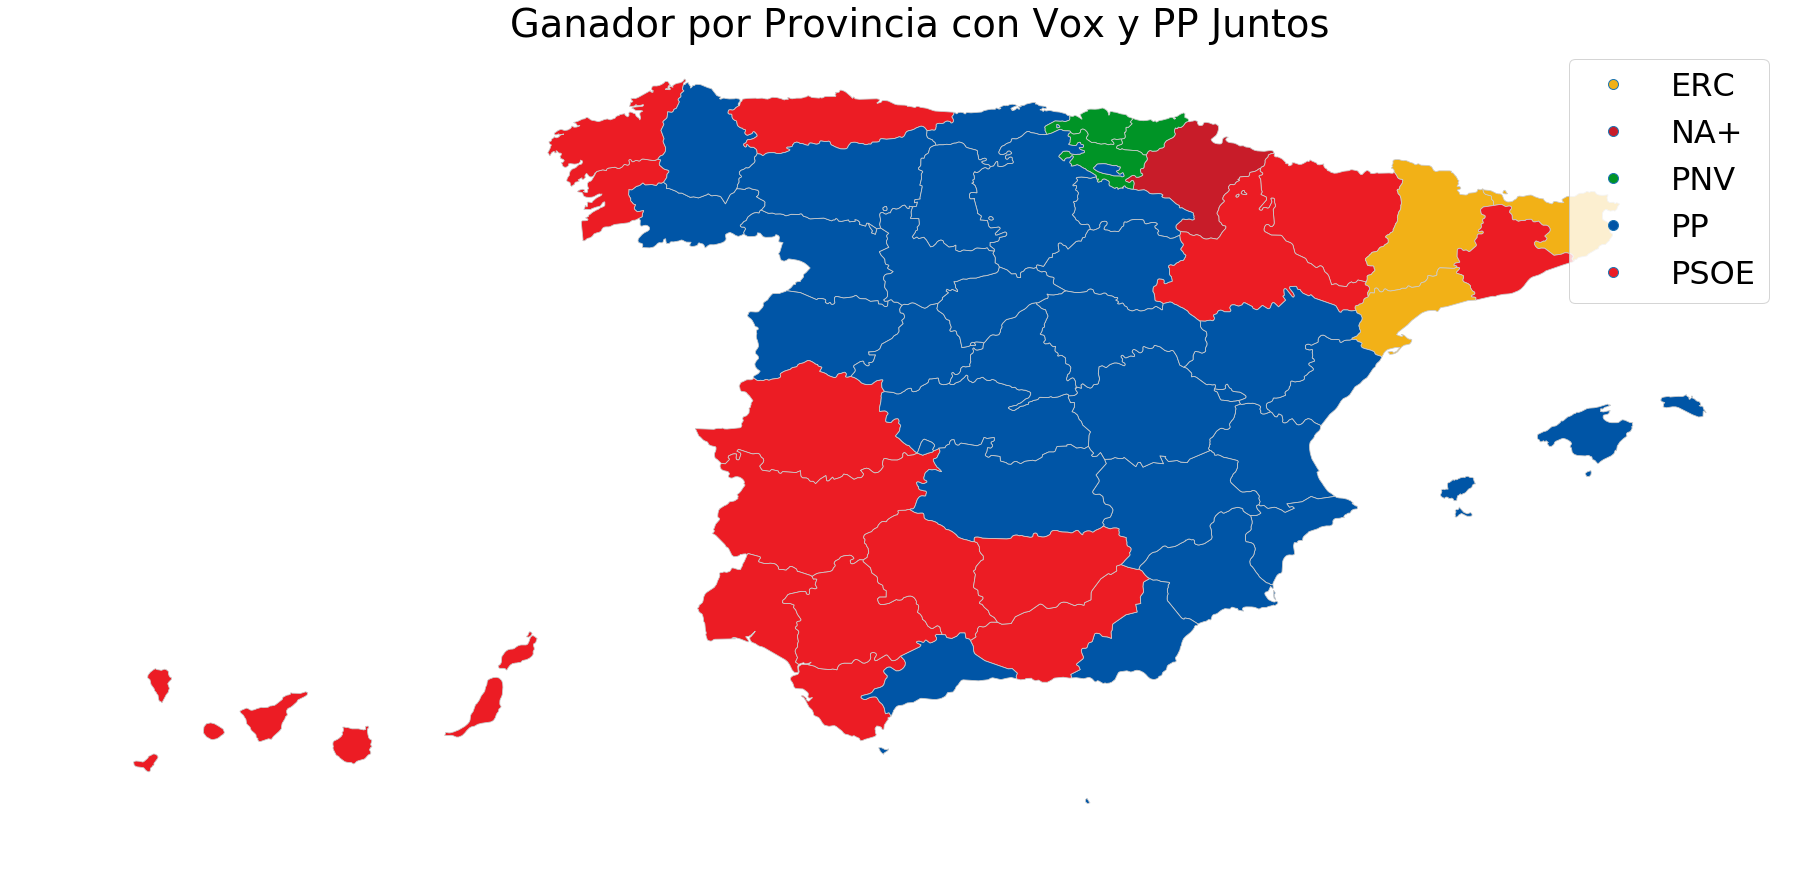

In [57]:
plt.rcParams.update({'font.size':32})

ax=mergePPVOX.plot(column=0,cmap=mycm,figsize=(31,19),linewidth=0.8,edgecolor='0.8',legend=True,categorical=True)
ax.set_axis_off()
ax.set_title('Ganador por Provincia con Vox y PP Juntos')
plt.savefig('mapa.jpg')

# Parlamento

In [58]:
sortedparl=ParlPPVOX[['Total']].sort_values(by='Total',ascending=False)

In [59]:
lab=list(sortedparl.index)
for l in range(7,len(lab)):
    lab[l]=''

In [60]:
def disp(pct):
    if pct>1.5:
        return '{:.0f}'.format(pct*3.5)

In [61]:
partcol=['#0055A7','#ED1C24','#FA5000','#6A2E68','#F3B217','#C40048','#009526','#A3C940','#FFDA1A','#E51C13','#DB6426','#BECD48']

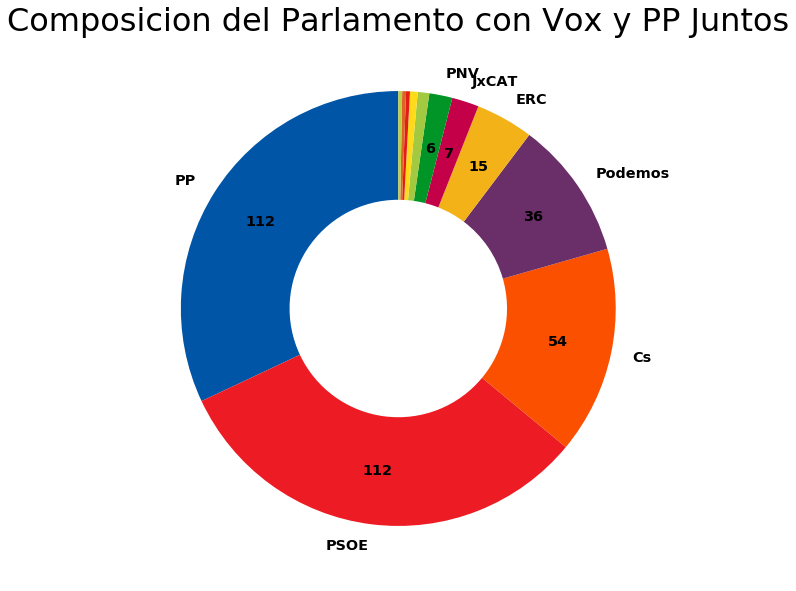

In [62]:
plt.rcParams.update({'font.size':12})

plt.figure(figsize=(10,10))
plt.pie(sortedparl,colors=partcol,wedgeprops=dict(width=0.5),startangle=90,labels=lab,autopct=lambda x: disp(x[0]),pctdistance=0.75,textprops={'fontsize':'large','weight':'bold'})
plt.title('Composicion del Parlamento con Vox y PP Juntos',fontdict={'fontsize':32})
plt.show()

# Diferencia

In [63]:
ConVox=Parl['Total'].sort_values(ascending=False)

In [64]:
SinVox=ParlPPVOX['Total'].sort_values(ascending=False)

In [65]:
col1=['#ED1C24','#0055A7','#FA5000','#6A2E68','#F3B217','#C40048','#009526','#A3C940','#FFDA1A','#E51C13','#DB6426','#BECD48']
colvox='#5AC035'

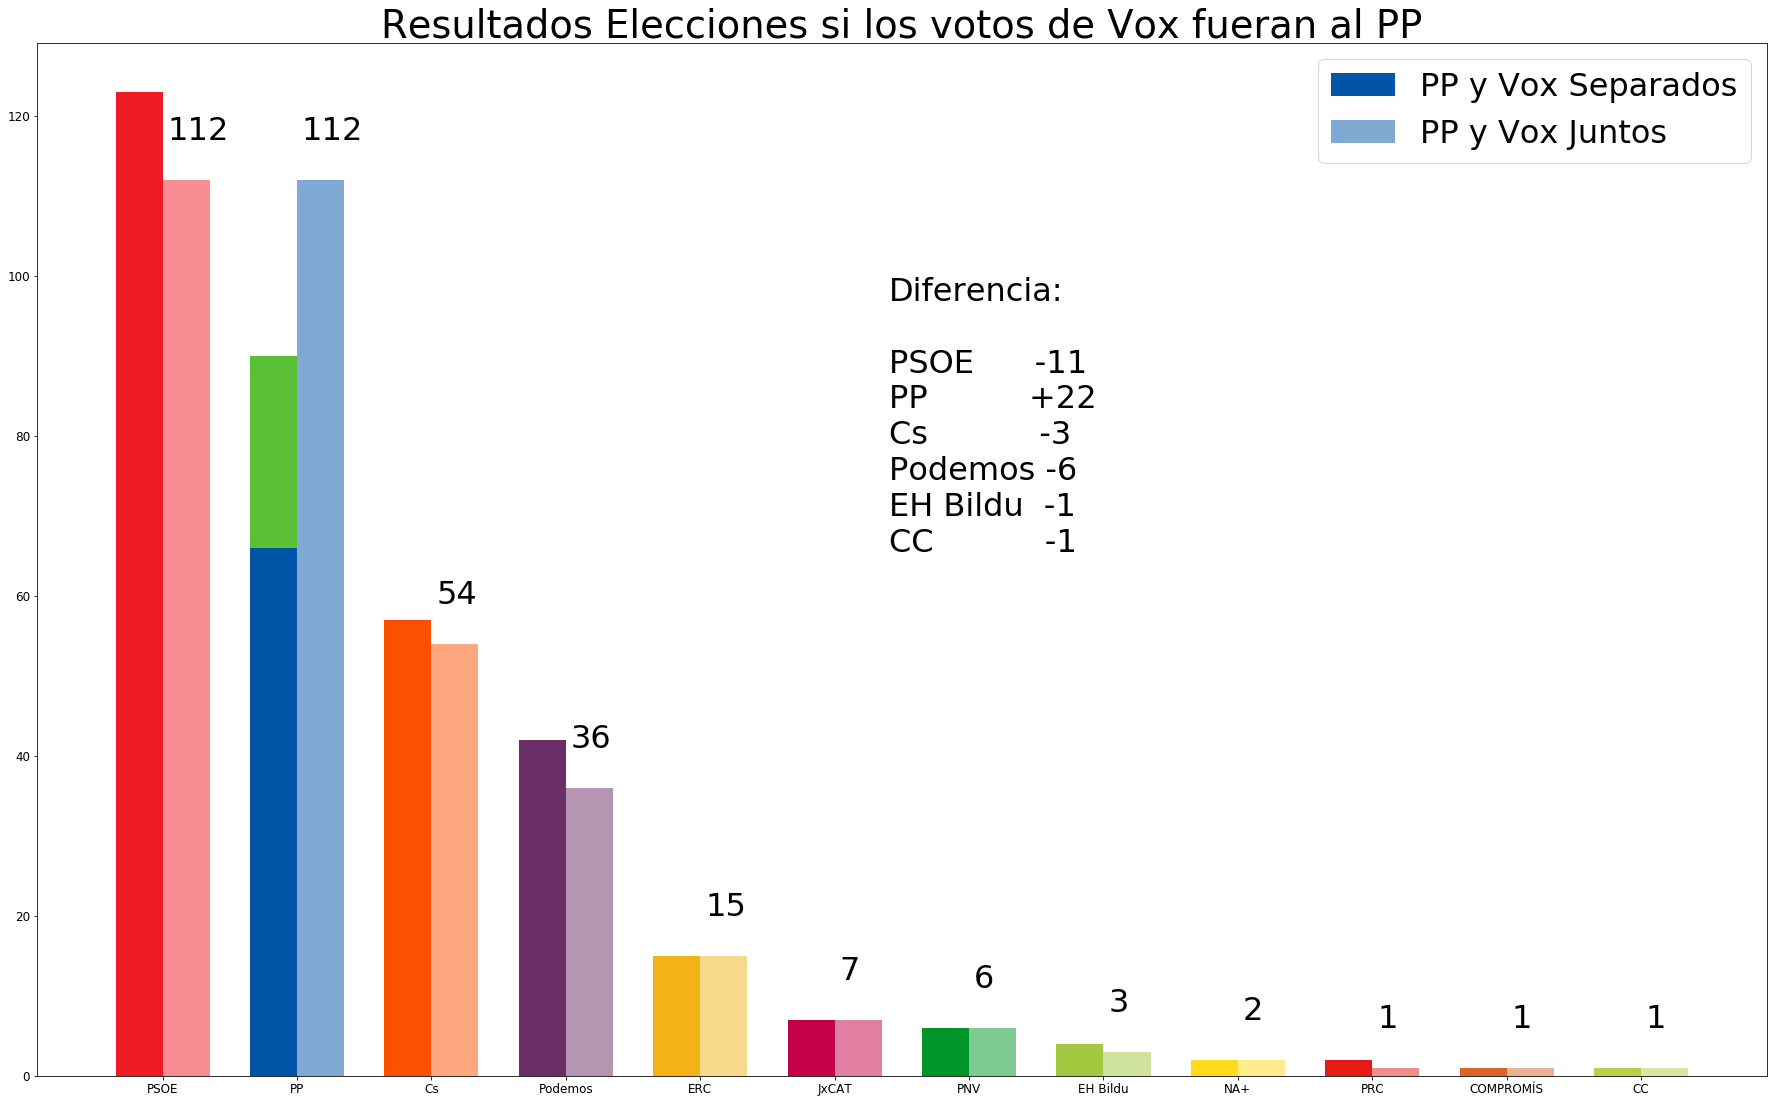

In [66]:
fig, ax=plt.subplots()

plt.rcParams.update({'font.size':32})
ind=np.arange(len(SinVox))
width=0.35
fig.set_size_inches(31,19)
p1 = ax.bar(ind,ConVox.drop('VOX'),width,color=col1)
p3 = ax.bar(1,ConVox['VOX'],width,color=colvox,bottom=ConVox['PP'])
p2 = ax.bar(ind+width,SinVox,width,color=col1,alpha=0.5)
ax.set_title('Resultados Elecciones si los votos de Vox fueran al PP')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(SinVox.index)
ax.legend((p1[1],p2[1]),('PP y Vox Separados','PP y Vox Juntos'))
ax.annotate(u'Diferencia:\n\nPSOE      -11\nPP          +22\nCs           -3\nPodemos -6\nEH Bildu  -1\nCC           -1',xy=(0.5,0.5),xycoords='figure fraction',fontsize=32)
for i in ind:
    ax.text(i+width*0.6,SinVox[i]+5,'{:.0f}'.format(SinVox[i]))
plt.savefig('parlamento.jpg')